In [1]:
import pandas as pd
import numpy as np
from utils import reduction_function as rfun
from utils import polarization_function as pfun
import networkx as nx
import csv 

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Making the network 

In [2]:
reclustered_monthly_data = pd.read_csv("../output_hpc/reclustered_monthly_data_final_june.csv", sep = "\t", encoding = "utf-8", quoting = csv.QUOTE_NONE )

In [3]:
# loading in the weekly networks 
network_data_22 = pd.read_csv("../22_06_networks/22_22_network.csv", sep = "\t")
network_data_23 = pd.read_csv("../22_06_networks/22_23_network.csv", sep = "\t")
network_data_24 = pd.read_csv("../22_06_networks/22_24_network.csv", sep = "\t")
network_data_25 = pd.read_csv("../22_06_networks/22_25_network.csv", sep = "\t")
print(network_data_22.shape[0] + network_data_23.shape[0] + network_data_24.shape[0] + network_data_25.shape[0])

500020


In [4]:
# merging into 1 edgelist for the entire month 
combined_network = pd.concat([network_data_22, network_data_23, network_data_24, network_data_25], ignore_index=True)
combined_network

,src,trg,nij,score
0,807295,1092821,1,0.984749
1,807295,845261,1,0.995268
2,807295,634859,2,0.997821
3,807295,606333,2,0.998815
4,807295,638312,1,0.986994
...,...,...,...,...
500015,1169065,1166104,11,0.999963
500016,282475,1167672,2,0.999921
500017,363577,215944,5,0.999984
500018,419760,902044,5,0.999979


In [5]:
user_nodeid = pd.read_csv("../reddit_22_51/user_nodeid.csv", sep = "\t")

In [6]:
required_topics = {1, 3, 12}

# 1. Filter the DataFrame to only include rows with topics 1, 3, or 12
df_filtered = reclustered_monthly_data[reclustered_monthly_data['topic'].isin(required_topics)]

# 2. Group by user and aggregate the set of topics they have written messages for
user_topics = df_filtered.groupby('user')['topic'].apply(set).reset_index()

# 3. Filter users who have written in all the required topics (1, 3, 12)
users_with_required_topics = user_topics[user_topics['topic'].apply(lambda x: required_topics.issubset(x))]

# 4. Extract the list of users who meet this condition
users = users_with_required_topics['user'].tolist()

In [7]:
network_users = user_nodeid[user_nodeid['index'].isin(users)]
network_userids = network_users["nodeid"].tolist()
network_data_filtered = combined_network[combined_network['src'].isin(network_userids) & combined_network['trg'].isin(network_userids)]

In [8]:
G = nx.from_pandas_edgelist(network_data_filtered, "src", 'trg')
print(G)

Graph with 2523 nodes and 23708 edges


In [9]:
largest_cc = max(nx.connected_components(G), key=len)

In [10]:
G_largest_cc = G.subgraph(largest_cc).copy()
print(G_largest_cc)

Graph with 2514 nodes and 23700 edges


In [11]:
network_users_combined = network_users[network_users["nodeid"].isin(G_largest_cc.nodes)]
network_users_combined

,index,nodeid
163,aletoledo,163
985,lemonparty,985
1030,stupendousman,1030
1829,PixelMagic,1829
2685,antidense,2685
...,...,...
1169403,slapmanutsup,1169403
1169530,SquarePie3646,1169530
1169695,Zeig_101,1169695
1169925,TJisbetterthanMyles,1169925


In [12]:
network_filtered = network_data_filtered[network_data_filtered['src'].isin(G_largest_cc.nodes) & network_data_filtered['trg'].isin(G_largest_cc.nodes)]
network_filtered

,src,trg,nij,score
180,638312,897056,9,0.994532
193,638312,304185,1,0.972685
195,638312,1143967,1,0.888734
198,638312,924811,1,0.956170
203,638312,38369,8,0.988113
...,...,...,...,...
496395,195043,641839,2,0.997240
496481,820950,1031058,1,0.999675
497350,419791,913272,1,0.999481
497721,349691,117260,1,0.999725


In [13]:
network_filtered.to_csv("../output_network/network_filtered_june.csv", sep="\t", index=False)

In [14]:
network_users_combined.to_csv("../output_network/network_users_combined_june.csv", sep="\t", index=False)

# Polarization code: 

In [15]:
net_file = pd.read_csv("../output_network/network_filtered_june.csv", sep="\t")
G = nx.from_pandas_edgelist(net_file, "src", "trg")
print(G)

Graph with 2514 nodes and 23700 edges


## Loading the labelled message files

In [16]:
import csv

In [17]:
abortion_df = pd.read_csv("../llama_probs/llama_probabilities_full_abortion_june.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)
marriage_df = pd.read_csv("../llama_probs/llama_probabilities_full_marriage_june.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)
political_df = pd.read_csv("../llama_probs/llama_probabilities_full_political_june.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)

In [18]:
abortion_df.shape, marriage_df.shape, political_df.shape

((106936, 13), (26616, 13), (42648, 13))

In [19]:
abortion_df = abortion_df[["user", "text", "topic", "A", "F", "N"]]
marriage_df = marriage_df[["user", "text", "topic", "A", "F", "N"]]
political_df = political_df[["user", "text", "topic", "A", "F", "N"]]
political_df.head()

,user,text,topic,A,F,N
0,fifaRAthrowaway,"We aren’t left wing, we just see what’s going ...",1,0.00000,0.412957,0.587043
1,BrotherPumpwell,Leftist here. I had to look it up because I've...,1,0.00000,1.000000,0.000000
2,DiNiCoBr,At around 08’-12’ a lot of Libertarians came t...,1,0.39212,0.098588,0.282076
3,Rush_Live,some of the leftist on twitter I interact with...,1,0.00000,0.919260,0.080740
4,stiKyNoAt,"Yeah, the only conservatives that troll reddit...",1,0.00000,1.000000,0.000000


In [20]:
political_df[(political_df["A"] == 0.0) & (political_df["F"] == 0.0) & (political_df["N"] == 0.0)]

,user,text,topic,A,F,N
16,Rush_Live,many of them claim to be leftist and no calls ...,1,0.0,0.0,0.0
20,Jizzlobber42,""""""" That's frustrating as Hell. There was a t...",1,0.0,0.0,0.0
30,shoot_your_eye_out,"""""""Like I said, some respect might do you well...",1,0.0,0.0,0.0
59,vanulovesyou,"""""""I've voted libertarian on the national leve...",1,0.0,0.0,0.0
92,Parkwaydrive777,"""""""You can predict whatever, idc, but personal...",1,0.0,0.0,0.0
...,...,...,...,...,...,...
42572,thelatesage,"""""""yeaaa... what We *really* need in America i...",1,0.0,0.0,0.0
42579,Ddec60,"Do you believe the press, law enforcement over...",1,0.0,0.0,0.0
42610,elmer_fudd65,I don't really identify with any party. Libert...,1,0.0,0.0,0.0
42617,Batsinvic888,"""""""Me: I'm pretty libertarian when it comes to...",1,0.0,0.0,0.0


Checking that users are in the graph G

In [21]:
user_nodeid = pd.read_csv("../reddit_22_51/user_nodeid.csv", sep="\t")
user_nodeid_dict = user_nodeid.set_index('index')['nodeid'].to_dict()
abortion_df['nodeid'] = abortion_df['user'].map(user_nodeid_dict) #mapping usernames to node ids
marriage_df['nodeid'] = marriage_df['user'].map(user_nodeid_dict)
political_df['nodeid'] = political_df['user'].map(user_nodeid_dict)

In [22]:
abortion_df_filtered = abortion_df[abortion_df['nodeid'].isin(G.nodes())] #filtering the users to be only those who wrote in all 3 topics (those form the graph)
marriage_df_filtered = marriage_df[marriage_df['nodeid'].isin(G.nodes())]
political_df_filtered = political_df[political_df['nodeid'].isin(G.nodes())]

### Selecting and averaging the stance probabilities 

In [23]:
abortion_df_avg = rfun.get_avg(abortion_df_filtered, "abortion") #getting the stance (from -1 to 1) from the probability
marriage_df_avg = rfun.get_avg(marriage_df_filtered, "marriage")
political_df_avg = rfun.get_avg(political_df_filtered, "political")

In [24]:
marriage_df_avg.shape

(2514, 5)

In [25]:
merged_df = rfun.merge_datasets(abortion_df_avg, marriage_df_avg, political_df_avg)
merged_df.shape

(2514, 13)

UMAP and PCA on the simulated data

In [26]:
merged_df.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political
0,-AmberSweet-,0.234323,0.543126,0.222551,-0.543126,0.500000,0.000000,0.500000,0.500000,0.000000,0.753546,0.246454,-0.753546
1,-Aquitaine-,0.217837,0.102957,0.459314,0.217837,0.130857,0.000000,0.869143,0.130857,0.177495,0.240602,0.518944,-0.240602
2,-Canuck21,0.736145,0.000000,0.263855,0.736145,1.000000,0.000000,0.000000,1.000000,0.526812,0.413390,0.000000,0.526812
3,-GregTheGreat-,0.000000,0.434897,0.565103,-0.434897,0.000000,0.000000,1.000000,0.000000,0.230872,0.505122,0.116524,-0.505122
4,-_Duke_-_-,0.851151,0.018964,0.095368,0.851151,0.102584,0.514068,0.383348,-0.514068,0.147939,0.404495,0.327894,-0.404495


In [27]:
merged_df_reduced = rfun.apply_pca(merged_df, ["stance_political", "stance_abortion", "stance_marriage"])
merged_df_reduced = rfun.apply_umap(merged_df, ["stance_political", "stance_abortion", "stance_marriage"])

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [28]:
merged_df_reduced.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political,pca_component,umap_component
0,-AmberSweet-,0.234323,0.543126,0.222551,-1.043672,0.500000,0.000000,0.500000,0.509177,0.000000,0.753546,0.246454,-0.867323,-0.743909,-0.698206
1,-Aquitaine-,0.217837,0.102957,0.459314,0.328051,0.130857,0.000000,0.869143,-0.110144,0.177495,0.240602,0.518944,0.110808,0.195373,-10.500942
2,-Canuck21,0.736145,0.000000,0.263855,1.262363,1.000000,0.000000,0.000000,1.348040,0.526812,0.413390,0.000000,1.574184,2.339767,14.547896
3,-GregTheGreat-,0.000000,0.434897,0.565103,-0.848578,0.000000,0.000000,1.000000,-0.329686,0.230872,0.505122,0.116524,-0.393604,-0.931436,3.633781
4,-_Duke_-_-,0.851151,0.018964,0.095368,1.469673,0.102584,0.514068,0.383348,-1.192152,0.147939,0.404495,0.327894,-0.201720,0.143894,9.532628


#### Saving the user scores in the format needed for the polaization code 

In [29]:
merged_df_reduced['nodeid'] = merged_df_reduced['user'].map(user_nodeid_dict) #mapping usernames to node ids

In [30]:
merged_df_reduced.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political,pca_component,umap_component,nodeid
0,-AmberSweet-,0.234323,0.543126,0.222551,-1.043672,0.500000,0.000000,0.500000,0.509177,0.000000,0.753546,0.246454,-0.867323,-0.743909,-0.698206,911729
1,-Aquitaine-,0.217837,0.102957,0.459314,0.328051,0.130857,0.000000,0.869143,-0.110144,0.177495,0.240602,0.518944,0.110808,0.195373,-10.500942,774844
2,-Canuck21,0.736145,0.000000,0.263855,1.262363,1.000000,0.000000,0.000000,1.348040,0.526812,0.413390,0.000000,1.574184,2.339767,14.547896,1092128
3,-GregTheGreat-,0.000000,0.434897,0.565103,-0.848578,0.000000,0.000000,1.000000,-0.329686,0.230872,0.505122,0.116524,-0.393604,-0.931436,3.633781,217112
4,-_Duke_-_-,0.851151,0.018964,0.095368,1.469673,0.102584,0.514068,0.383348,-1.192152,0.147939,0.404495,0.327894,-0.201720,0.143894,9.532628,1159547


In [31]:
merged_df_reduced["nodeid"]

0        911729
1        774844
2       1092128
3        217112
4       1159547
         ...   
2509    1152146
2510    1159857
2511     646840
2512     616749
2513     396556
Name: nodeid, Length: 2514, dtype: int64

##### Polarization code 

In [32]:
pfun.calc_pol4(G, merged_df_reduced, "pca_component")

             user       A_x       F_x       N_x  stance_abortion       A_y  \
0    -AmberSweet-  0.234323  0.543126  0.222551        -1.043672  0.500000   
1     -Aquitaine-  0.217837  0.102957  0.459314         0.328051  0.130857   
2       -Canuck21  0.736145  0.000000  0.263855         1.262363  1.000000   
3  -GregTheGreat-  0.000000  0.434897  0.565103        -0.848578  0.000000   
4      -_Duke_-_-  0.851151  0.018964  0.095368         1.469673  0.102584   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.000000  0.500000         0.509177  0.000000  0.753546  0.246454   
1  0.000000  0.869143        -0.110144  0.177495  0.240602  0.518944   
2  0.000000  0.000000         1.348040  0.526812  0.413390  0.000000   
3  0.000000  1.000000        -0.329686  0.230872  0.505122  0.116524   
4  0.514068  0.383348        -1.192152  0.147939  0.404495  0.327894   

   stance_political  pca_component  umap_component   nodeid  
0         -0.867323      -0.743909  

np.float64(27.43031381796055)

In [33]:
pfun.calc_pol4(G, merged_df_reduced, "umap_component")

             user       A_x       F_x       N_x  stance_abortion       A_y  \
0    -AmberSweet-  0.234323  0.543126  0.222551        -1.043672  0.500000   
1     -Aquitaine-  0.217837  0.102957  0.459314         0.328051  0.130857   
2       -Canuck21  0.736145  0.000000  0.263855         1.262363  1.000000   
3  -GregTheGreat-  0.000000  0.434897  0.565103        -0.848578  0.000000   
4      -_Duke_-_-  0.851151  0.018964  0.095368         1.469673  0.102584   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.000000  0.500000         0.509177  0.000000  0.753546  0.246454   
1  0.000000  0.869143        -0.110144  0.177495  0.240602  0.518944   
2  0.000000  0.000000         1.348040  0.526812  0.413390  0.000000   
3  0.000000  1.000000        -0.329686  0.230872  0.505122  0.116524   
4  0.514068  0.383348        -1.192152  0.147939  0.404495  0.327894   

   stance_political  pca_component  umap_component   nodeid  
0         -0.867323      -0.743909  

np.float64(347.26790715661)

### Results:
Polarization on the PCA component: 16.697074410642806

Polarization on the UMAP component: 119.47712444892863

Some plots of the network:

In [34]:
import numpy as np
import matplotlib.pyplot as plt
 
def plot_c_subplot(merged_df, pc_column, color_topics):
    num_plots = len(color_topics)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)
 
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one plot
 
    for i, (color_topic, ax) in enumerate(zip(color_topics, axes)):
        num_users = merged_df.shape[0]
        y_axis = np.random.rand(num_users)
 
        scatter = ax.scatter(merged_df[pc_column], y_axis, c=merged_df[color_topic], cmap='coolwarm')
        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label(f'{color_topic} stance')
 
        ax.set_xlabel('UMAP component' if pc_column == "umap_component" else 'Principal component')
        if i == 0:
            ax.set_ylabel('Random')  # Label only on first plot
        ax.set_title(f'Scatter plot - {color_topic}')
 
    plt.tight_layout()
    plt.show()

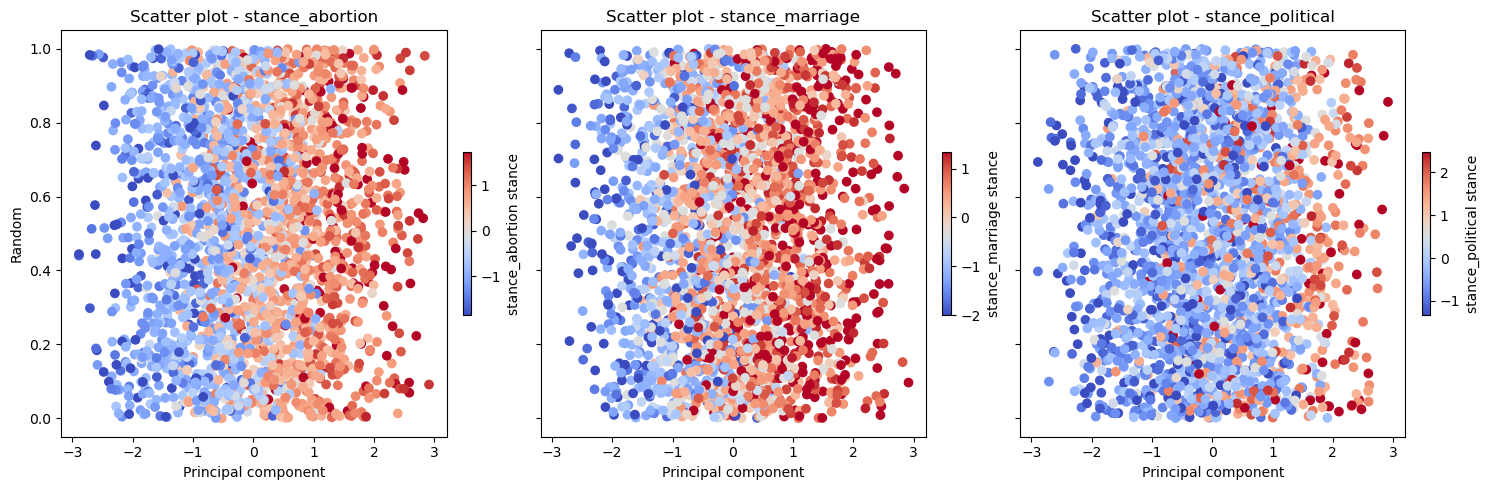

In [35]:
plot_c_subplot(merged_df_reduced, "pca_component", ["stance_abortion", "stance_marriage", "stance_political"])

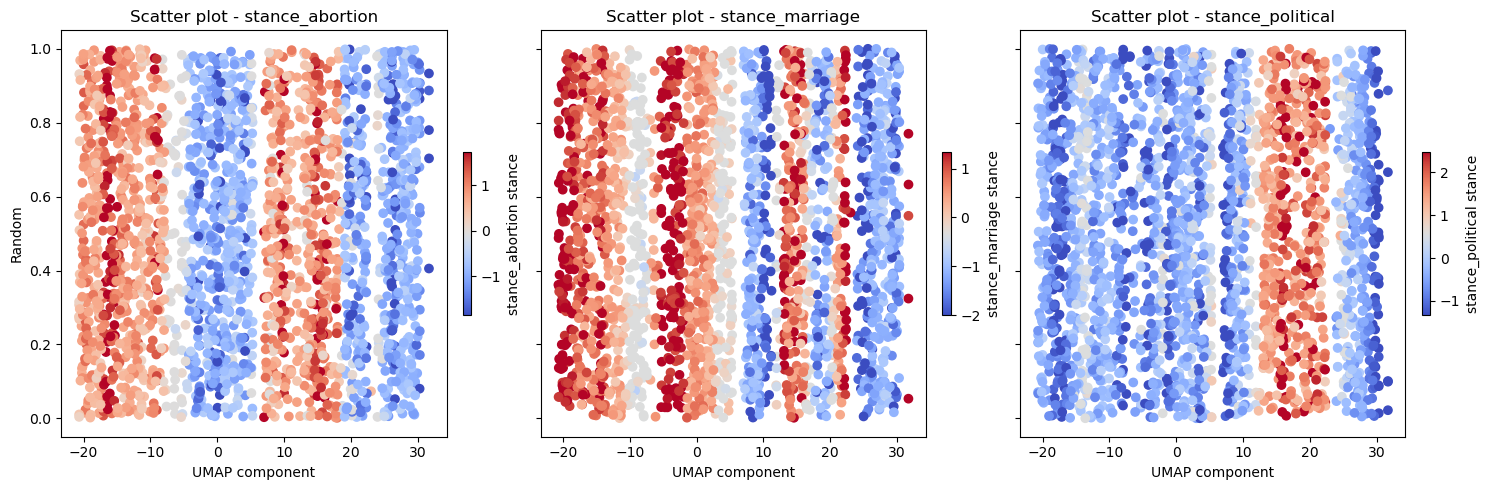

In [36]:
plot_c_subplot(merged_df_reduced, "umap_component", ["stance_abortion", "stance_marriage", "stance_political"])

Dividing pca scores by 2 to get them between -1 and 1 

In [37]:
merged_df_reduced["pca_component_scaled"] = merged_df_reduced["pca_component"]/2

In [38]:
# polarization 
pfun.calc_pol4(G, merged_df_reduced, "pca_component_scaled")

             user       A_x       F_x       N_x  stance_abortion       A_y  \
0    -AmberSweet-  0.234323  0.543126  0.222551        -1.043672  0.500000   
1     -Aquitaine-  0.217837  0.102957  0.459314         0.328051  0.130857   
2       -Canuck21  0.736145  0.000000  0.263855         1.262363  1.000000   
3  -GregTheGreat-  0.000000  0.434897  0.565103        -0.848578  0.000000   
4      -_Duke_-_-  0.851151  0.018964  0.095368         1.469673  0.102584   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.000000  0.500000         0.509177  0.000000  0.753546  0.246454   
1  0.000000  0.869143        -0.110144  0.177495  0.240602  0.518944   
2  0.000000  0.000000         1.348040  0.526812  0.413390  0.000000   
3  0.000000  1.000000        -0.329686  0.230872  0.505122  0.116524   
4  0.514068  0.383348        -1.192152  0.147939  0.404495  0.327894   

   stance_political  pca_component  umap_component   nodeid  \
0         -0.867323      -0.743909 

np.float64(13.715156908980275)

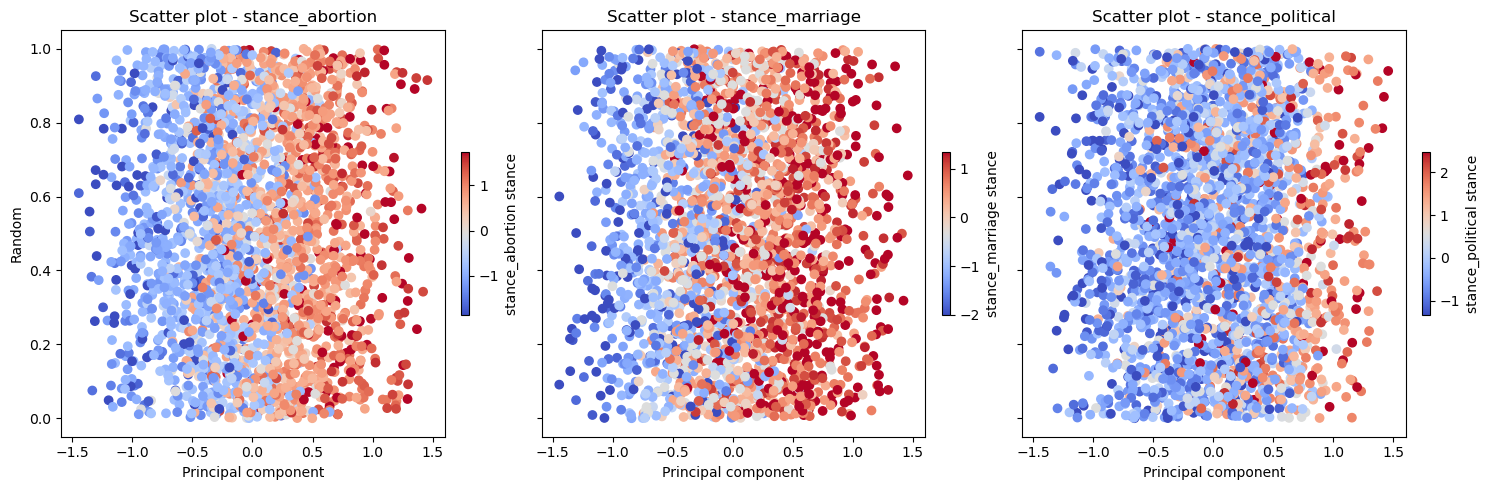

In [39]:
plot_c_subplot(merged_df_reduced, "pca_component_scaled", ["stance_abortion", "stance_marriage", "stance_political"])